# Part 3 - Create a dumbbell topology
Create a dumbbell topology as in Fig. 1 (considering all links with a 10 Mb/s
capacity and a propagation delay of 5 ms) and test the behaviour of TCP New Reno,
Vegas, and Cubic as a function of n: how does the congestion window change? How does
the delay change?

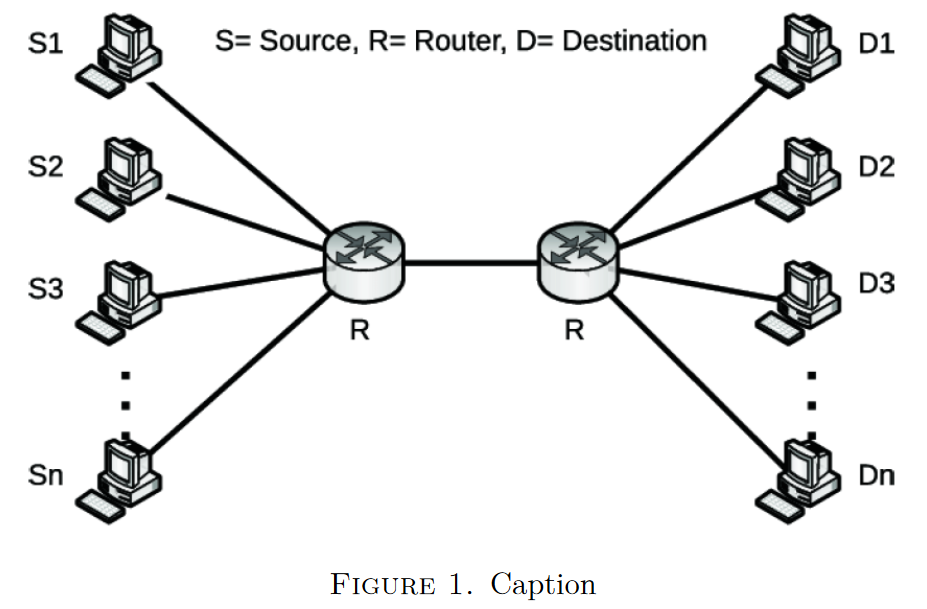


### Code
The following code is used to make the Dumbel topologi and gather the data used in the result. 

In [ ]:
from mininet.topo import Topo
from mininet.net import Mininet
from mininet.node import Node
from mininet.log import setLogLevel, info
from mininet.cli import CLI
from mininet.link import TCLink
from mininet.util import quietRun
import time
import subprocess
import os

class DumbellTopo(Topo):    
    def build(self,N,  **_opts):
        self.N = N
        bandwidth = 10
        delay= 5
        
        IP1 = '192.168.1.1/24'  # Ip Address for r0-eth1
        IP2 = '192.1.56.1/56'  # IP address for r1-eth1
        source = []
        dest = []
        routers = [self.addSwitch('R1'), self.addSwitch('R2')]
        self.addLink(routers[0],routers[1], bw = bandwidth, delay=delay, cls=TCLink, max_queue_size=21*delay, loss = 1)
        for i in range(self.N): 
            #Create Source and destination
            source.append(self.addHost("S{1}".format(i)))
            dest.append(self.addHost("D{1}".format(i)))
            # Create link 
            self.addLink(source[i],routers[0], bw = bandwidth, delay=delay, cls=TCLink, max_queue_size=21*delay, loss = 1)
            self.addLink(routers[1],dest[i], bw = bandwidth, delay=delay, cls=TCLink, max_queue_size=21*delay, loss = 1)

def cleanProbe():
    print("Removing existing TCP_Probe")
    procs = quietRun('pgrep -f /proc/net/tcpprobe').split()
    for proc in procs:
        output= quietRun('sudo kill -KILL {0}'.format(proc.rstrip()))

def TCP_prob(TCP_type,N):
    tcp_prob_dataPath = "{1}/{2}/TcpProbeData.txt".format(TCP_type,N)
    if(os.path.exists(tcp_prob_dataPath)):
        print("removing existing file")
        os.remove(tcp_prob_dataPath)
    cleanProbe()
    print("Starting TCP_PROBE........")
    output = quietRun('sudo rmmod tcp_probe')
    output = quietRun('sudo modprobe tcp_probe port=5001')
    print("Storing the TCP_Probe results")
    subprocess.Popen("sudo cat /proc/net/tcpprobe > {1}".format(tcp_prob_dataPath), shell=True)



global iperfDuration
iperfDuration = 30

def run(TCP_type, NuberOfSourceAndDest):
    "Test"
    topo = DumbellTopo(N = NuberOfSourceAndDest)
    datapath= "{1}/{2}/".format(TCP_type,N)
    net = Mininet(topo=topo)
    net.start()
    net.pingAll()
    source = [net.getNodeByName('S{1}'.format(i)) for i in range (topo.N)]
    dest = [net.getNodeByName('D{1}'.format(i)) for i in range (topo.N)]
    
    TCP_prob(TCP_type=TCP_type, N=NuberOfSourceAndDest)

    popens = dict()
    # net.iperf([source[1],dest[-1]],l4Type='TCP')
    for i in range(topo.N):
        print("Starting the server on the host S{1}".format(i))
        popens[source[i]]= source[i].popen(["iperf -s -p 5001 -i 1 -Z {1} > {datapath}S{2}.txt".format(TCP_type,i)], shell=True)
        
    time.sleep(1)
    
    for i in range(topo.N):
        popens[dest[i]]= dest[i].popen(["iperf -c {1} -p 5001 -t {2} > {3}D{4}.txt".format(source[i].IP(),iperfDuration,datapath,i)], shell=True)
    
    for i in range(topo.N):
           popens[dest[i]].wait()

    print("Done Iperf")
    #CLI(net)
    # os.system("sudo sh iperf3.sh")

    net.stop()

if __name__ == '__main__':
    setLogLevel('info')
    TCP_types=["reno","vegas","cubic"]
    for TCP_type in TCP_types:
        for N in range(1,10):
            if(not(os.path.exists("{1}/{2}".format(TCP_type,N)))):
                os.mkdir("{1}/{2}".format(TCP_type,N))
            run(TCP_type=TCP_type,NuberOfSourceAndDest=N)



## Results


We start by looking at the bandwidth of the Dumbbell topologi
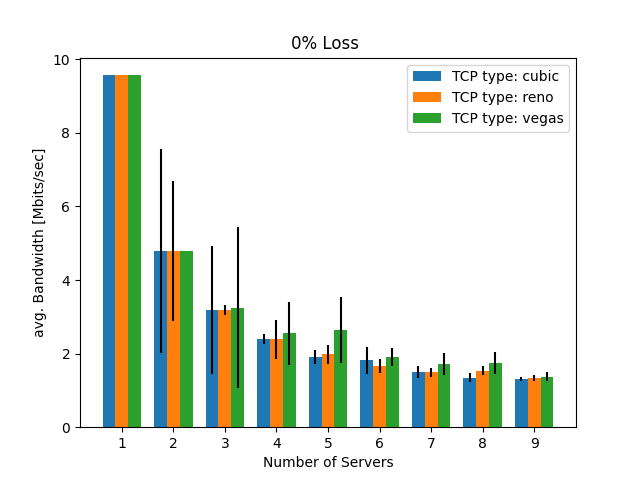




Here it can be seen that the avarage bandwith is nearly the same of all TCP-types - Howevere with more useres vegas archive higher bandwith. The Black bars indicate the varience of the bandwidth over alle useres and 1 second intervals.  

## CNWD and Queue
To say something about the CNWD have we used the TCB_probe and XXX on the egress of the Queue between the Switches. We have chosen to higligth som of the CNWD and Queue length. 

### 2 User. 
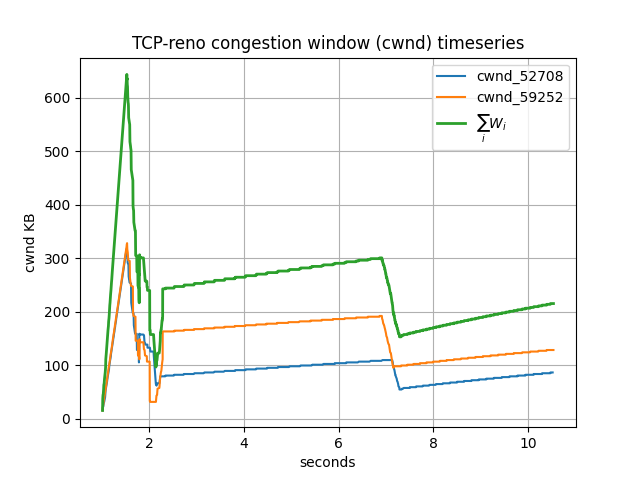
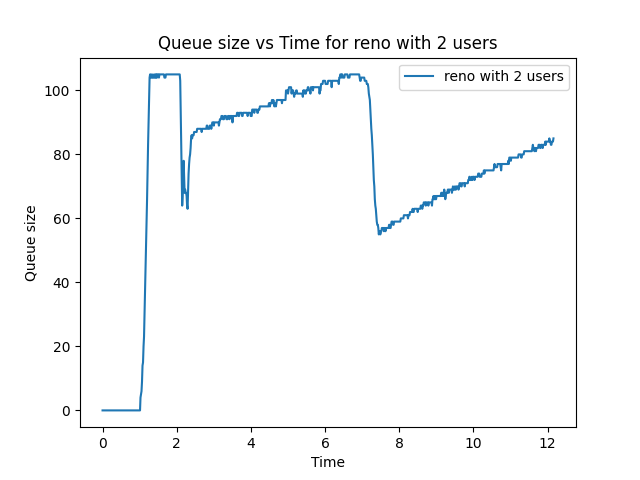

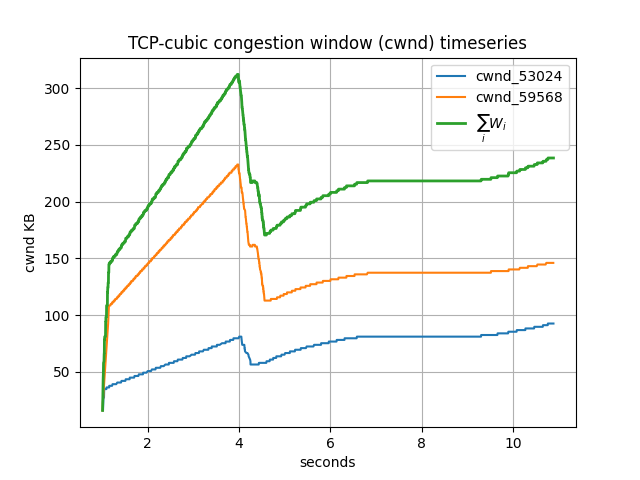
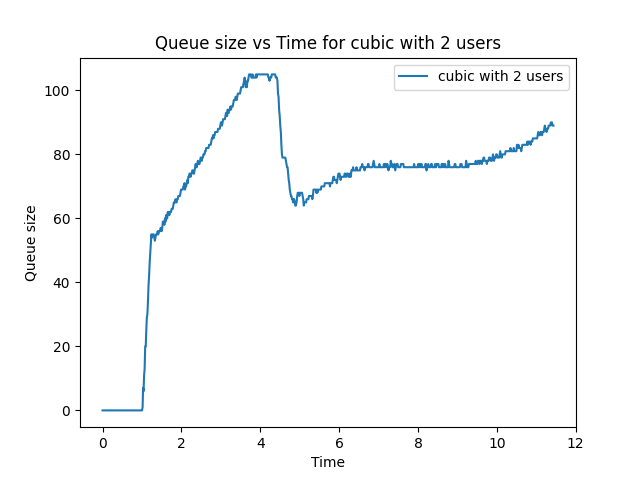

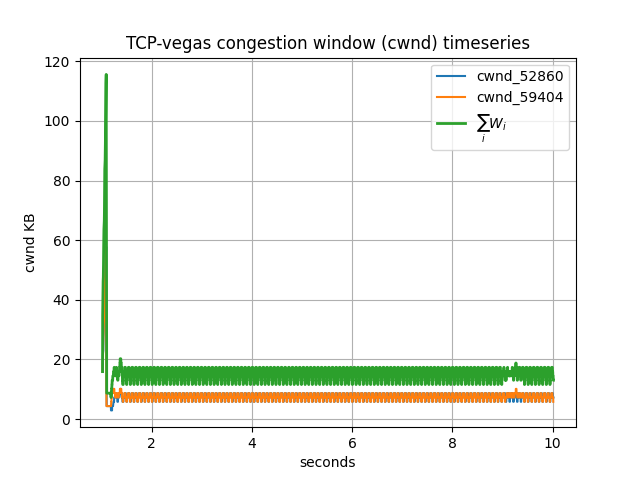
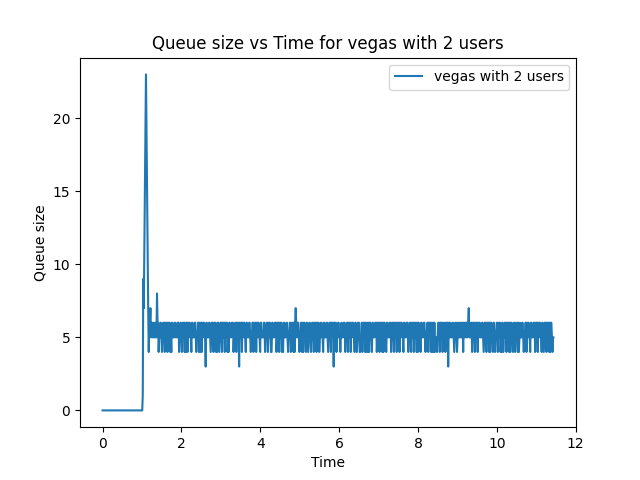




## 5 Users 
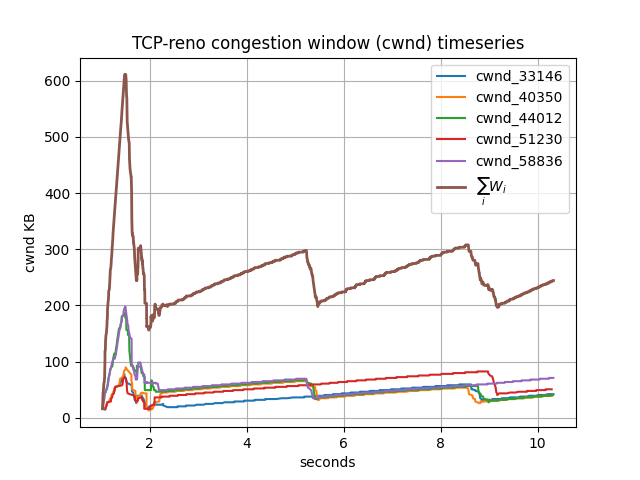
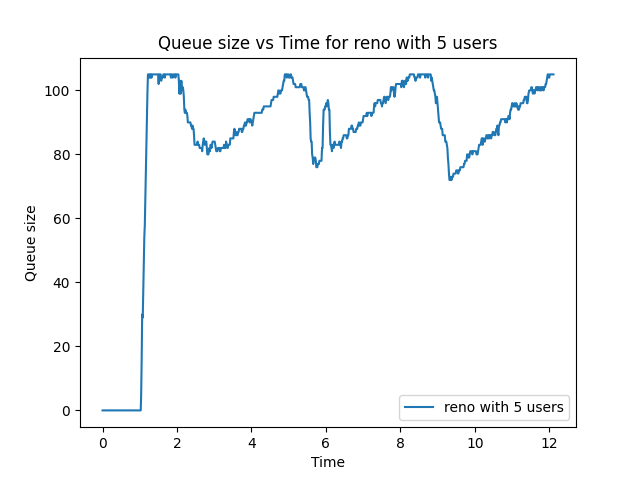

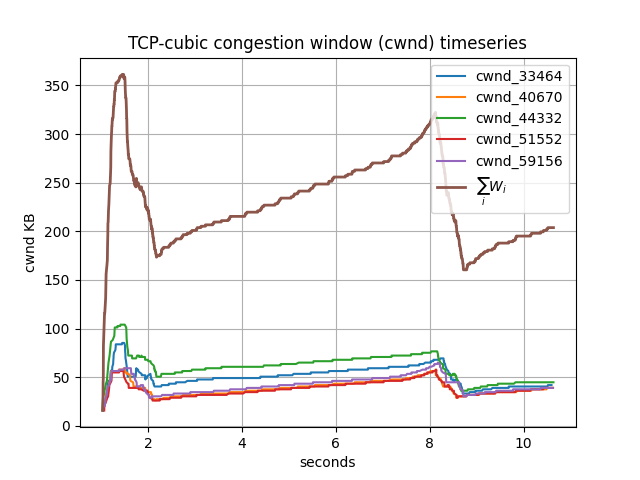
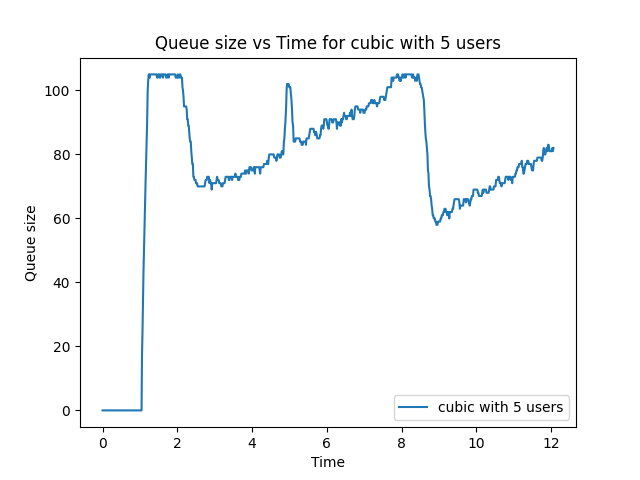

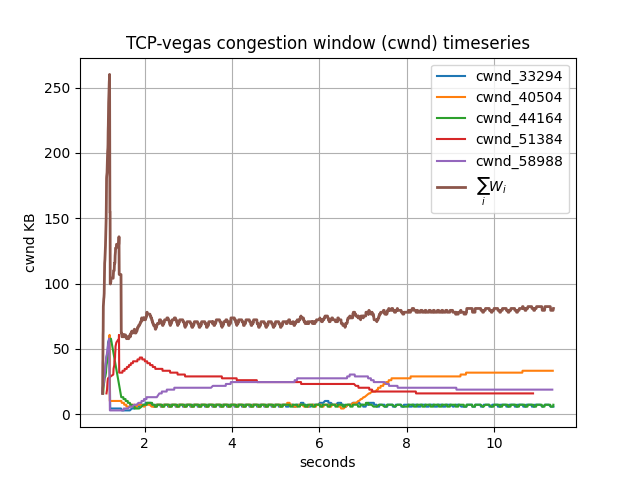
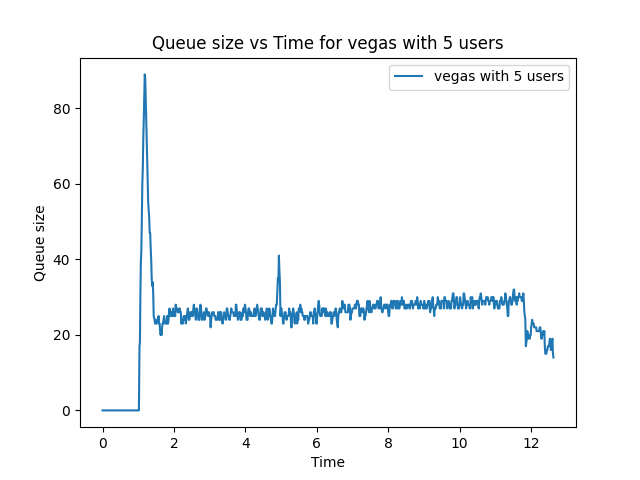

## 9 Users
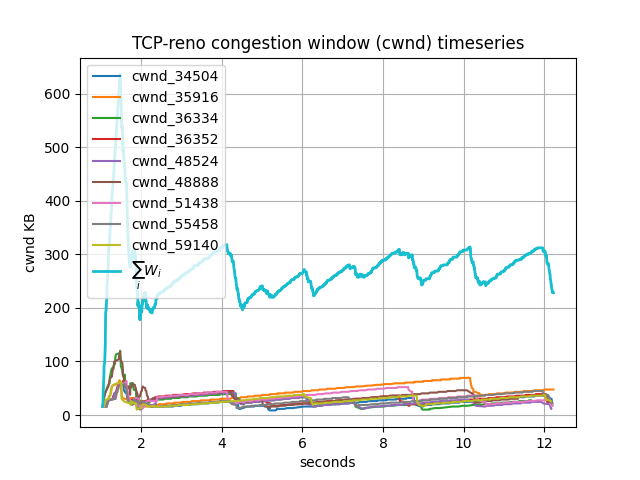
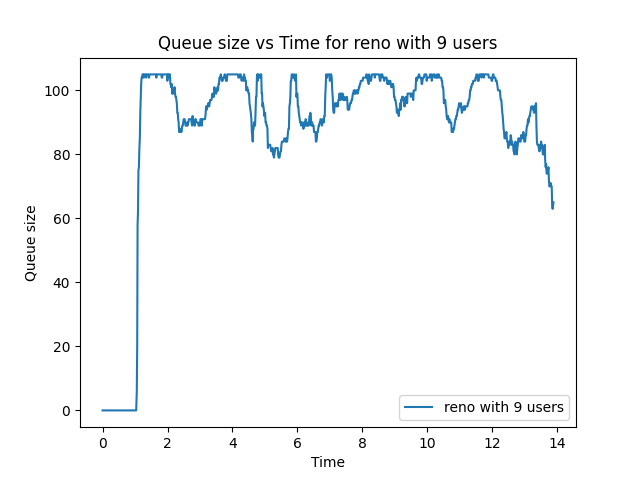

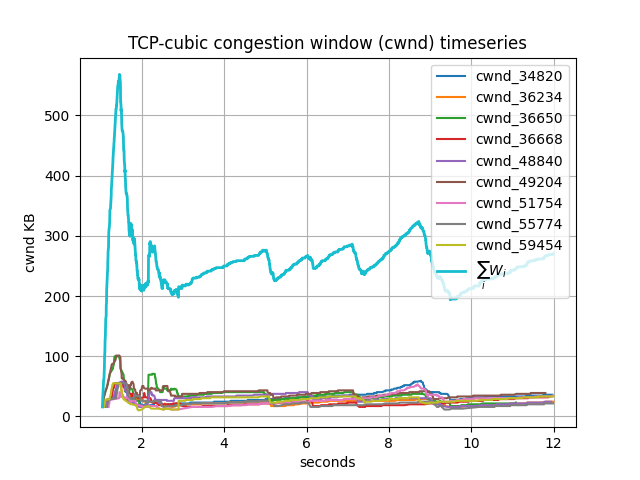
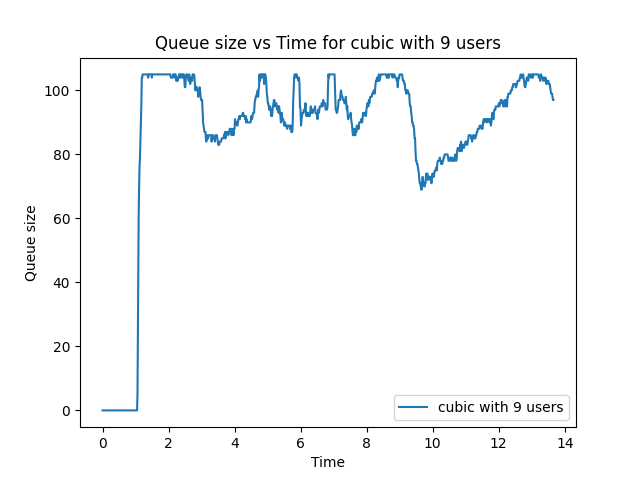

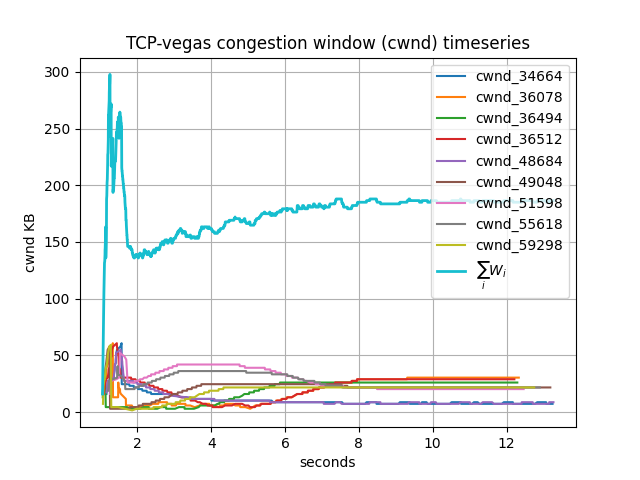
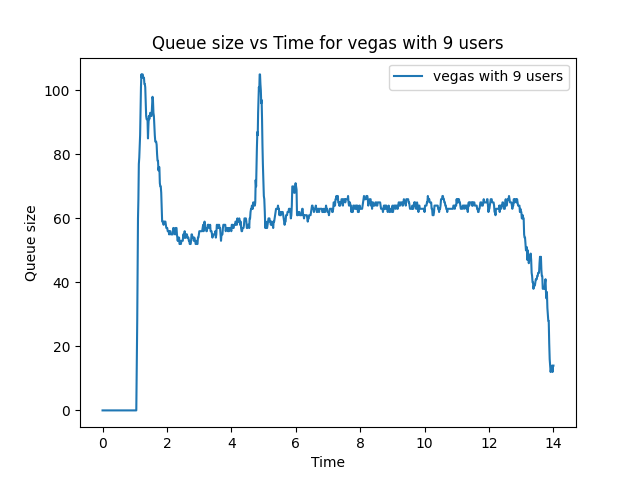


### Observations 
#### Reno:
It can be seen that when the number of useres increass is reption ack obserede more often, resulting in the fast recoverry. The Queue is also more congestiode resulting in more stabe but also longer Queue times.    

#### Cubic: 
As with Reno is the queue more congestide as the number of useres rices, resulting in more stabe but also longer Queue and here by longer queue times.    

#### Vegas:
It can be seen that the Queue size increase as the number of userer increases. This wil result in higher delays. It is also observede that it takes longer time for the CNWD to settel. The Vegas useres howevere experiance lower delay on avarage, wich is what to be expexted. 

# Repeat the experiment, but introduce a packet loss rate of 1%. How do the results change?
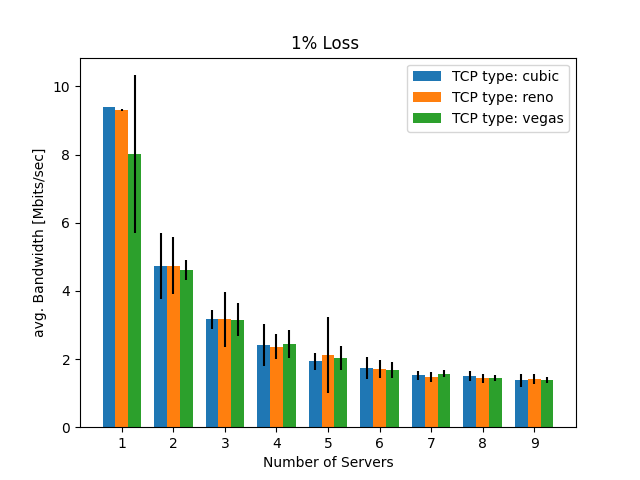

Vegas does not pull a head when more users is added as was obserevede i the case with 0 loss. From the CNWD and Queue data it can be observede that the queue of the Vegas TCP control is much more unstable as a result of the 1\% loss. The Queue sizes is in gereal much lower as 3 duplicate ACK is now also generated from loss insted of only overflows in queues. Cubic and Reno CNWD is heavly redused, but it can also be seen that the bandwidth is much more equaly spread over the diffrent users.
  



## Reno 
### 2 Users
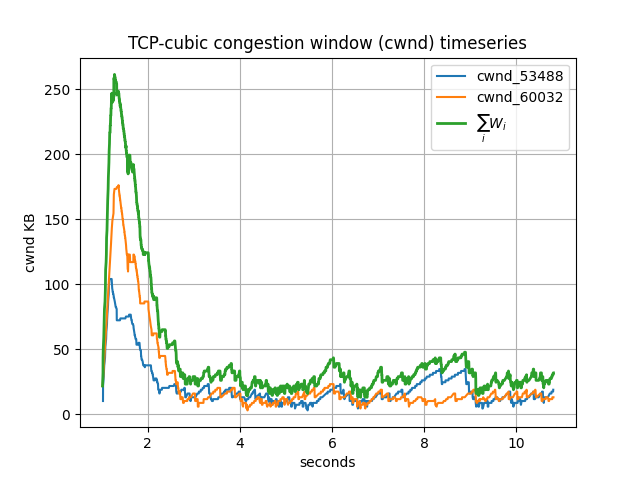
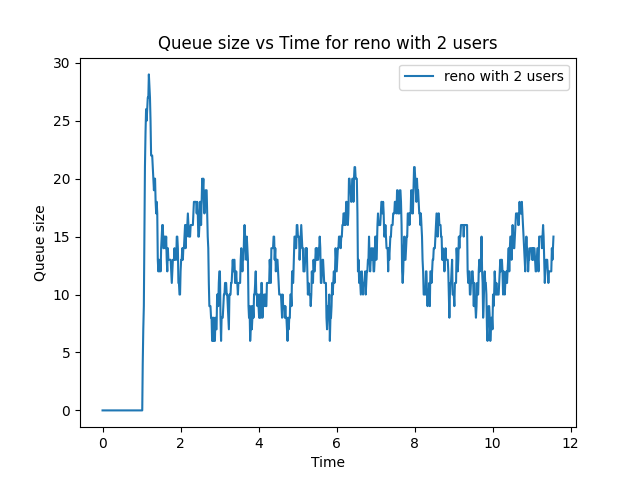
### 5 Users
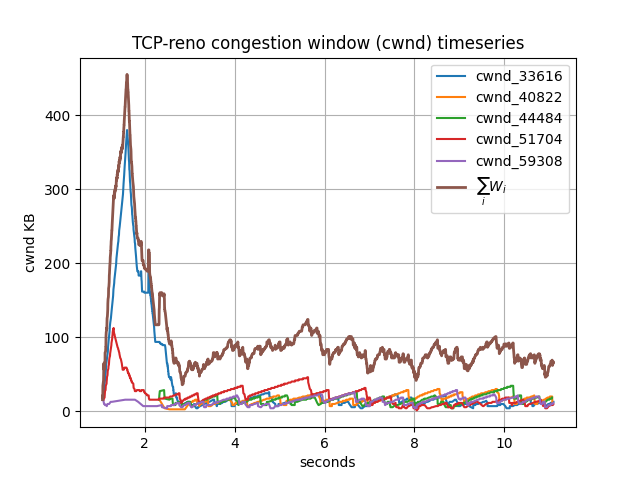
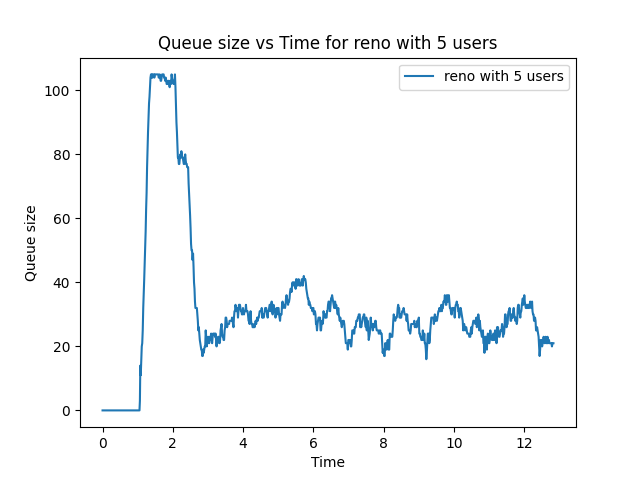
### 9 Users
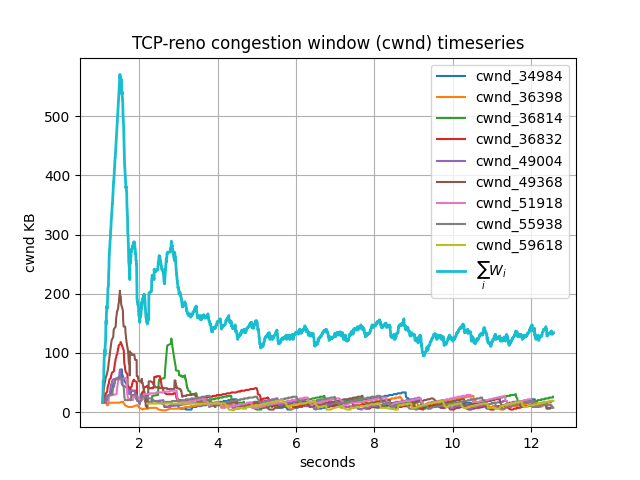
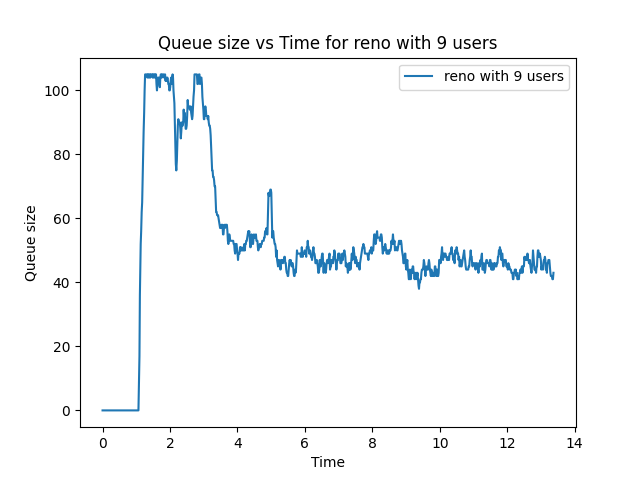

## Cubic 
### 2 Users
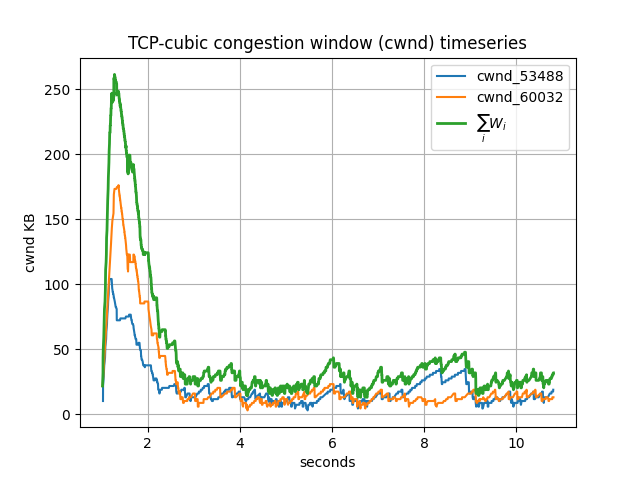
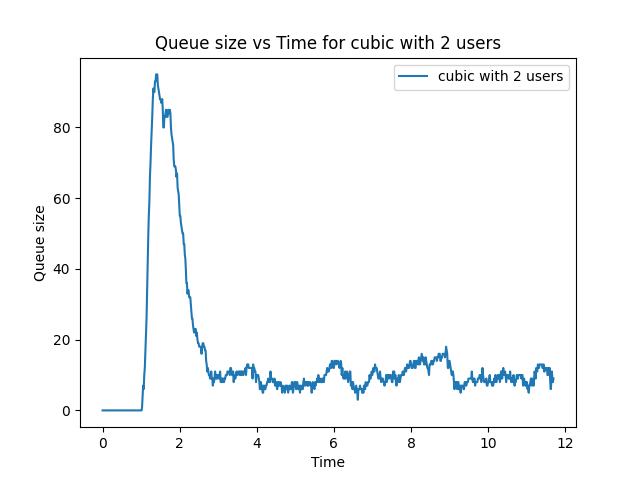

### 5 Users
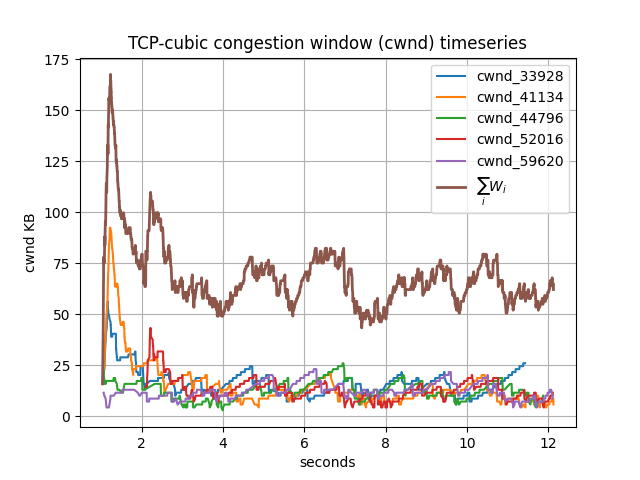
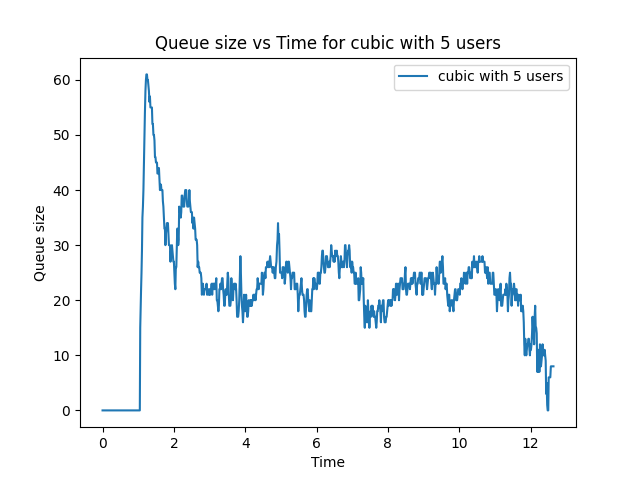

### 9 Users
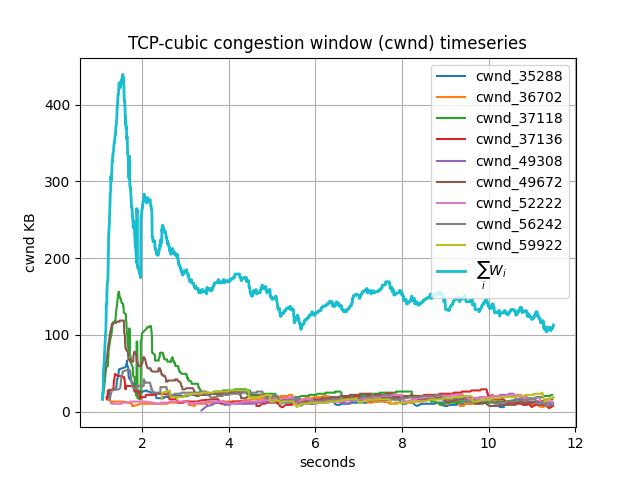
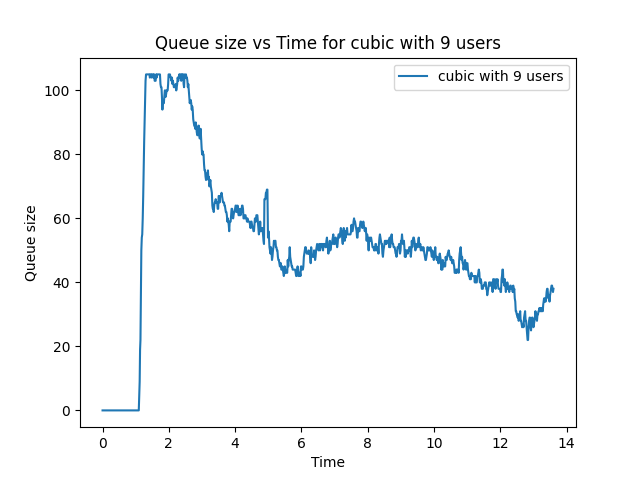

## Vegas
### 2 Users
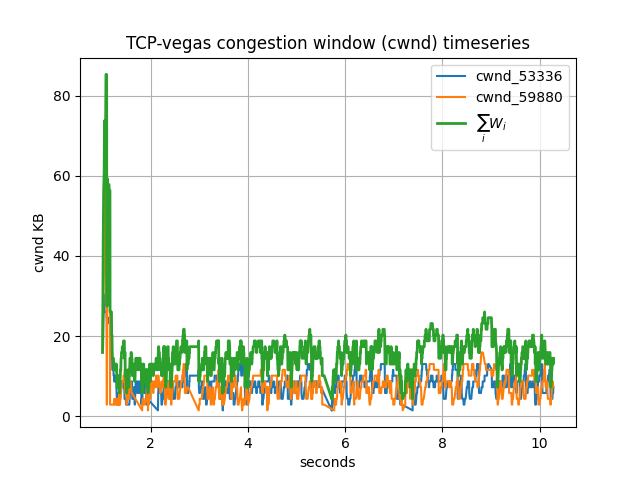
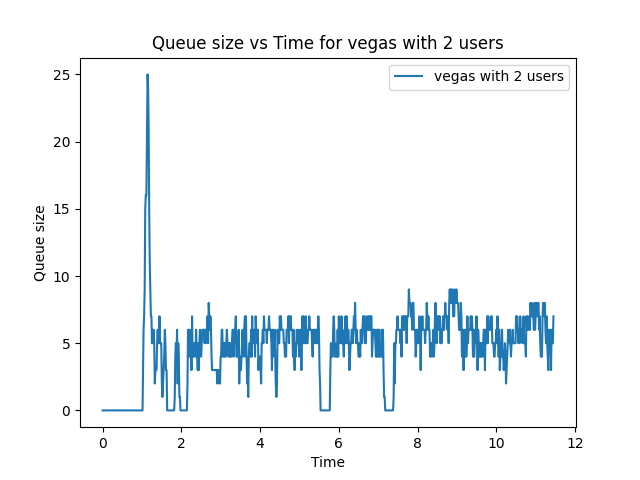

### 5 Users
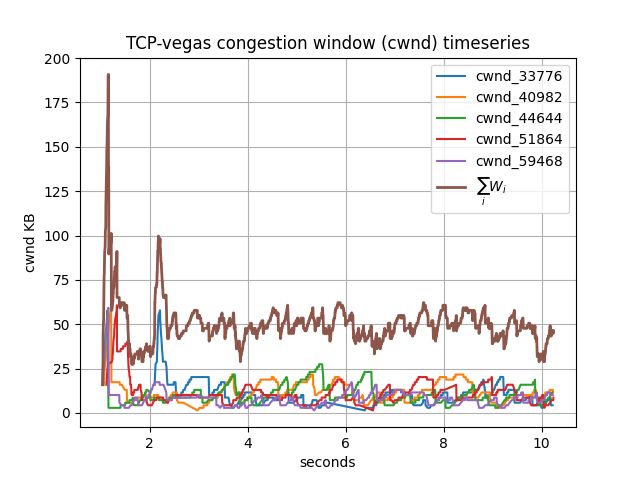
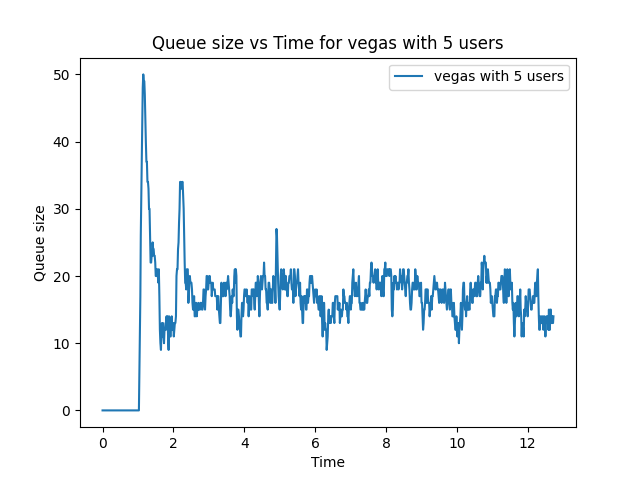

### 9 Users
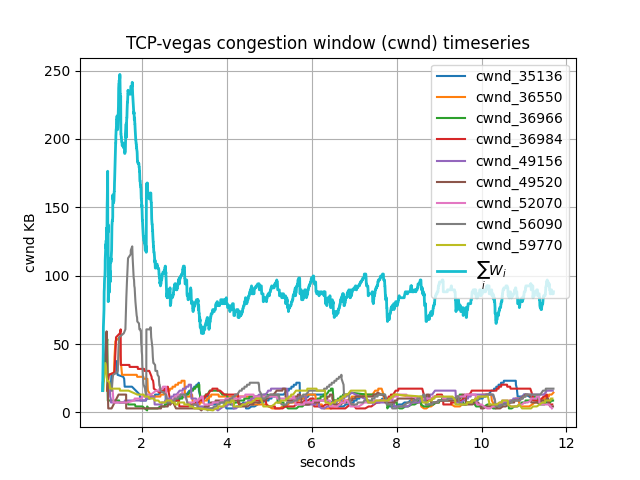
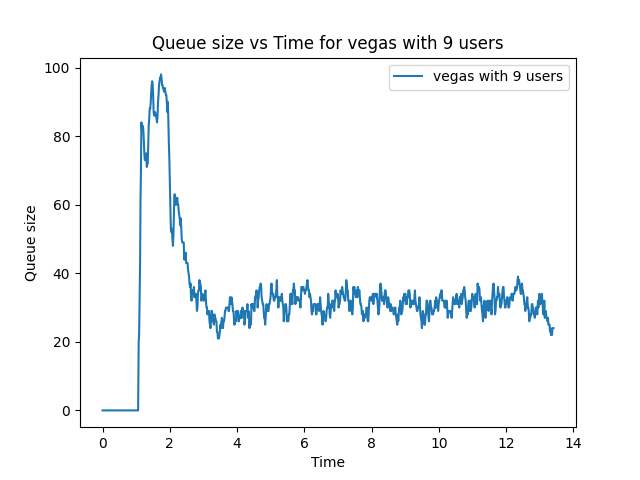

# Guide on how to set the test enviorment up.

- As we want to use the TCP_probe to monitor the CNWD, we need to use a old version of Ubuntu 16.04, a image of witch can be found on mininets website http://mininet.org/download/, as a VM we used Vitual Machine Manager with tmux to get multiple terminals.
- After setting up the VM, set up the mininet enviorment following this guide. https://github.com/mininet/mininet/wiki/Environment-Setup 
- Here after you can run the Bufferbloat exercises to gather the data. 
- You need to copy the file out of the VM to make the figures as MathPlotlib does not work in ubuntu 16.04 (Can probaly be fixed with virtual enviroments, but it is easyer just to transfer the files)

- In the part 3 and 4 we choose to use the python API for mininet, combinede with the monitoring script from the bufferbloat exercies. 
- We where not able to get CNWD on BBR as the new kernal version that support BBR does not support TCP_probe. 


